# Nature-Inspired Optimization for Local SHAP Explanations

This notebook implements optimization algorithms (GA, PSO, SA) to find minimal feature subsets that preserve both prediction and SHAP explanation fidelity.

## Key Implementation Details

1. **SHAP Values**: Extracted only for the positive class (class 1) and returned as 1D vectors of shape `(n_features,)`
2. **Explainer Reuse**: The same SHAP explainer is reused across all fitness evaluations to avoid reinitialization
3. **Feature Constraint**: At least one feature must be selected in every candidate solution (enforced in all algorithms and fitness function)


In [53]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from ucimlrepo import fetch_ucirepo
import shap
from scipy.stats import pearsonr
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# ----------------------------------------------------------------------------
# 1. Model Training Module
# ----------------------------------------------------------------------------
def train_rf(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=5, random_state=42):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Random Forest Test Accuracy: {acc:.4f}")
    print(f"Random Forest Test F1-Score: {f1:.4f}")
    return rf, acc, f1

# ----------------------------------------------------------------------------
# 2. SHAP Explanation Module
# ----------------------------------------------------------------------------
def compute_shap(rf_model, X_instance, explainer=None):
    if explainer is None:
        explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_instance)

    if isinstance(shap_values, list):
        if len(shap_values) >= 2:
            shap_positive = np.array(shap_values[1])
        else:
            shap_positive = np.array(shap_values[0])
    else:
        shap_positive = np.array(shap_values)

    if len(shap_positive.shape) == 1:
        pass
    elif len(shap_positive.shape) == 2:
        if shap_positive.shape[0] == 1: shap_positive = shap_positive[0]
        elif shap_positive.shape[1] == 2: shap_positive = shap_positive[:, 1]
        elif shap_positive.shape[0] == 2: shap_positive = shap_positive[1, :]
        else: shap_positive = shap_positive.flatten()
    elif len(shap_positive.shape) == 3:
        if shap_positive.shape[2] == 2: shap_positive = shap_positive[0, :, 1]
        else: shap_positive = shap_positive.flatten()
    else:
        shap_positive = shap_positive.flatten()

    return np.array(shap_positive).flatten(), explainer

# ----------------------------------------------------------------------------
# 3. Fitness Function Module
# ----------------------------------------------------------------------------
def fitness_function(x, model, X_instance, X_train, full_shap, full_pred,
                     explainer=None, alpha=1.0, beta=1.0, gamma=0.1):
    if np.sum(x) == 0: return 1e10
    mask = np.array(x, dtype=bool)
    baseline = X_train.mean(axis=0)
    X_masked = X_instance.copy()
    unselected_cols = X_instance.columns[~mask]
    for col in unselected_cols:
        baseline_val = float(baseline[col])
        if X_masked[col].dtype != float: X_masked[col] = X_masked[col].astype(float)
        X_masked.loc[:, col] = baseline_val

    y_masked = model.predict_proba(X_masked)[0, 1]
    pred_error = np.abs(full_pred - y_masked)

    if explainer is None: explainer = shap.TreeExplainer(model)
    shap_values_masked = explainer.shap_values(X_masked)
    if isinstance(shap_values_masked, list):
        shap_masked = np.array(shap_values_masked[1])
    else:
        shap_masked = np.array(shap_values_masked)

    if len(shap_masked.shape) == 1: pass
    elif len(shap_masked.shape) == 2:
        if shap_masked.shape[1] == 2: shap_masked = shap_masked[:, 1]
        elif shap_masked.shape[0] == 1: shap_masked = shap_masked[0]
        else: shap_masked = shap_masked.flatten()
    elif len(shap_masked.shape) == 3:
        if shap_masked.shape[2] == 2: shap_masked = shap_masked[0, :, 1]
        else: shap_masked = shap_masked.flatten()
    else: shap_masked = shap_masked.flatten()

    shap_masked = np.array(shap_masked).flatten()
    full_shap_1d = np.array(full_shap).flatten()
    
    # Use Pearson correlation for SHAP fidelity
    if np.all(shap_masked == 0) or np.std(shap_masked) == 0:
        fidelity_error = 1.0  # Maximum error if no signal
    else:
        corr, _ = pearsonr(full_shap_1d, shap_masked)
        fidelity_error = 1 - corr  # We want to minimize this
    
    sparsity = np.sum(x) / len(x)
    return alpha * pred_error + beta * fidelity_error + gamma * sparsity

# ----------------------------------------------------------------------------
# 4. Genetic Algorithm Module
# ----------------------------------------------------------------------------
def genetic_algorithm(fitness_func, n_features, n_population=50, n_generations=100,
                     crossover_rate=0.8, mutation_rate=0.1, random_state=42):
    np.random.seed(random_state)
    random.seed(random_state)
    population = []
    for _ in range(n_population):
        ind = np.random.randint(0, 2, n_features)
        if np.sum(ind) == 0: ind[np.random.randint(0, n_features)] = 1
        population.append(ind)
    population = np.array(population)
    fitness_scores = np.array([fitness_func(ind) for ind in population])
    best_idx = np.argmin(fitness_scores)
    best_sol = population[best_idx].copy()
    best_fit = fitness_scores[best_idx]
    history = [best_fit]

    for generation in range(n_generations):
        new_pop = []
        for _ in range(n_population):
            idx1, idx2 = np.random.choice(n_population, 2, replace=False)
            winner = idx1 if fitness_scores[idx1] < fitness_scores[idx2] else idx2
            new_pop.append(population[winner].copy())
        new_pop = np.array(new_pop)

        for i in range(0, n_population - 1, 2):
            if np.random.rand() < crossover_rate:
                cp = np.random.randint(1, n_features)
                new_pop[i, cp:], new_pop[i+1, cp:] = new_pop[i+1, cp:].copy(), new_pop[i, cp:].copy()
                if np.sum(new_pop[i]) == 0: new_pop[i, np.random.randint(0, n_features)] = 1
                if np.sum(new_pop[i+1]) == 0: new_pop[i+1, np.random.randint(0, n_features)] = 1

        for i in range(n_population):
            for j in range(n_features):
                if np.random.rand() < mutation_rate:
                    new_pop[i, j] = 1 - new_pop[i, j]
            if np.sum(new_pop[i]) == 0: new_pop[i, np.random.randint(0, n_features)] = 1

        population = new_pop
        fitness_scores = np.array([fitness_func(ind) for ind in population])
        curr_best_idx = np.argmin(fitness_scores)
        if fitness_scores[curr_best_idx] < best_fit:
            best_fit = fitness_scores[curr_best_idx]
            best_sol = population[curr_best_idx].copy()
        history.append(best_fit)
    return best_sol, best_fit, history

# ----------------------------------------------------------------------------
# 5. Particle Swarm Optimization Module
# ----------------------------------------------------------------------------
def binary_pso(fitness_func, n_features, n_particles=30, n_iterations=100,
               w=0.7, c1=1.5, c2=1.5, random_state=42):
    np.random.seed(random_state)
    positions = []
    velocities = np.random.uniform(-4, 4, (n_particles, n_features))
    for _ in range(n_particles):
        pos = np.random.randint(0, 2, n_features)
        if np.sum(pos) == 0: pos[np.random.randint(0, n_features)] = 1
        positions.append(pos)
    positions = np.array(positions)
    p_best_pos = positions.copy()
    p_best_fit = np.array([fitness_func(pos) for pos in positions])
    g_best_idx = np.argmin(p_best_fit)
    g_best_pos = p_best_pos[g_best_idx].copy()
    g_best_fit = p_best_fit[g_best_idx]
    history = [g_best_fit]

    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(n_features), np.random.rand(n_features)
            velocities[i] = w * velocities[i] + c1 * r1 * (p_best_pos[i] - positions[i]) + c2 * r2 * (g_best_pos - positions[i])
            velocities[i] = np.clip(velocities[i], -4, 4)
            sigmoid = 1 / (1 + np.exp(-velocities[i]))
            positions[i] = (np.random.rand(n_features) < sigmoid).astype(int)
            if np.sum(positions[i]) == 0: positions[i, np.random.randint(0, n_features)] = 1
            curr_fit = fitness_func(positions[i])
            if curr_fit < p_best_fit[i]:
                p_best_fit[i] = curr_fit
                p_best_pos[i] = positions[i].copy()
                if curr_fit < g_best_fit:
                    g_best_fit = curr_fit
                    g_best_pos = positions[i].copy()
        history.append(g_best_fit)
    return g_best_pos, g_best_fit, history

# ----------------------------------------------------------------------------
# 6. Simulated Annealing Module
# ----------------------------------------------------------------------------
def simulated_annealing(fitness_func, n_features, initial_temp=100.0,
                       final_temp=0.01, cooling_rate=0.95, iterations_per_temp=10,
                       random_state=42):
    np.random.seed(random_state)
    curr_sol = np.random.randint(0, 2, n_features)
    if np.sum(curr_sol) == 0: curr_sol[np.random.randint(0, n_features)] = 1
    curr_fit = fitness_func(curr_sol)
    best_sol, best_fit = curr_sol.copy(), curr_fit
    history = [curr_fit]
    temp = initial_temp
    while temp > final_temp:
        for _ in range(iterations_per_temp):
            neighbor = curr_sol.copy()
            idx = np.random.randint(0, n_features)
            neighbor[idx] = 1 - neighbor[idx]
            if np.sum(neighbor) == 0: neighbor[np.random.randint(0, n_features)] = 1
            n_fit = fitness_func(neighbor)
            delta = n_fit - curr_fit
            if delta < 0 or np.random.rand() < np.exp(-delta / temp):
                curr_sol, curr_fit = neighbor, n_fit
                if curr_fit < best_fit: best_sol, best_fit = curr_sol.copy(), curr_fit
            history.append(curr_fit)
        temp *= cooling_rate
    return best_sol, best_fit, history

## 1. Dataset Loading & Inspection


In [ ]:
# Load Chronic Kidney Disease dataset using ucimlrepo
from ucimlrepo import fetch_ucirepo

# Fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# Extract features and targets
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

# Handle missing values - use mean imputation for numeric columns
print(f"Missing values before handling:\n{X.isnull().sum()}")
X = X.fillna(X.mean(numeric_only=True))

# For any remaining object columns, fill with mode
for col in X.select_dtypes(include=['object']).columns:
    mode_val = X[col].mode()
    if len(mode_val) > 0:
        X[col] = X[col].fillna(mode_val[0])
    else:
        X[col] = X[col].fillna(0)

# Handle categorical features - convert to numeric
# First, identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    # For binary categorical features, encode as 0/1
    # For multi-category features, use one-hot encoding
    binary_cats = []
    multi_cats = []

    for col in categorical_cols:
        if X[col].nunique() == 2:
            binary_cats.append(col)
        else:
            multi_cats.append(col)

    # Encode binary categoricals as 0/1
    for col in binary_cats:
        X[col] = pd.Categorical(X[col]).codes

    # One-hot encode multi-category features
    if len(multi_cats) > 0:
        X = pd.get_dummies(X, columns=multi_cats, drop_first=True)

    # Final check: if any object columns remain, use get_dummies
    remaining_cats = X.select_dtypes(include=['object']).columns.tolist()
    if len(remaining_cats) > 0:
        X = pd.get_dummies(X, columns=remaining_cats, drop_first=True)

# Ensure all features are numeric (final check)
if X.select_dtypes(include=['object']).shape[1] > 0:
    X = pd.get_dummies(X, drop_first=True)

# Binarize target: Convert 'ckd' (chronic kidney disease) to 1, 'notckd' to 0
# Handle both DataFrame and Series formats
if isinstance(y, pd.DataFrame):
    y_values = y.iloc[:, 0].values if y.shape[1] > 0 else y.values.ravel()
else:
    y_values = y.values.ravel() if hasattr(y, 'values') else np.array(y).ravel()

# Handle string targets (ckd/notckd) or numeric targets
if len(y_values) > 0:
    if isinstance(y_values[0], str):
        # String targets: 'ckd' -> 1, 'notckd' -> 0
        y_binary = (y_values == 'ckd').astype(int)
    else:
        # Numeric targets: assume 1 = ckd, 0 = notckd (or similar encoding)
        y_binary = (y_values > 0).astype(int) if np.max(y_values) > 1 else y_values.astype(int)
else:
    raise ValueError("Target variable is empty")

print(f"\nTarget distribution: {np.bincount(y_binary)}")
print(f"Features shape: {X.shape}")
print(f"All features numeric: {X.select_dtypes(exclude=[np.number]).shape[1] == 0}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=RANDOM_STATE, stratify=y_binary
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# Display dataset metadata
print("\n" + "="*60)
print("Dataset Metadata:")
print("="*60)
metadata = chronic_kidney_disease.metadata
print(f"Dataset Name: {metadata.get('name', 'N/A')}")
print(f"Number of Instances: {metadata.get('num_instances', 'N/A')}")
print(f"Number of Features: {metadata.get('num_features', 'N/A')}")
print(f"Feature Types: {metadata.get('feature_types', 'N/A')}")
print(f"Has Missing Values: {metadata.get('has_missing_values', 'N/A')}")

print("\n" + "="*60)
print("Variable Information:")
print("="*60)
if hasattr(chronic_kidney_disease, 'variables') and chronic_kidney_disease.variables is not None:
    print(chronic_kidney_disease.variables)
else:
    print("Variable info not available")

print("\n" + "="*60)
print("Data Summary:")
print("="*60)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nFeature names: {list(X_train.columns)}")
print(f"\nTraining target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")
print(f"\nAll features numeric: {X_train.select_dtypes(exclude=[np.number]).shape[1] == 0}")
print(f"Target is binary: {len(np.unique(y_train)) == 2}")


Missing values before handling:
age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64

Target distribution: [152 248]
Features shape: (400, 25)
All features numeric: False

Train shape: (280, 25), Test shape: (120, 25)

Dataset Metadata:
Dataset Name: Chronic Kidney Disease
Number of Instances: 400
Number of Features: 24
Feature Types: ['Real']
Has Missing Values: yes

Variable Information:
     name     role         type demographic              description  \
0     age  Feature      Integer         Age                     None   
1      bp  Feature      Integer        None           blood pressure   
2      sg  Feature  Categorical        None         specific gravity   
3      al  Feature  Categorical        None    

## 2. Model Training (Black-Box Model)


In [ ]:
# Train Random Forest classifier
rf_model, test_accuracy, test_f1 = train_rf(
    X_train, y_train, X_test, y_test,
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_STATE
)

print(f"\nModel Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Ensure model has reasonable performance
if test_accuracy < 0.7:
    print("\nWarning: Model accuracy is below 0.7. Consider adjusting hyperparameters.")
else:
    print("\nModel performance is acceptable for SHAP explanations.")


Random Forest Test Accuracy: 0.9833
Random Forest Test F1-Score: 0.9867

Model Performance:
Test Accuracy: 0.9833
Test F1-Score: 0.9867

Model performance is acceptable for SHAP explanations.


## 3. Local SHAP Explanation (Baseline)


In [ ]:
# Select one instance from test set for local explanation
instance_idx = 0  # Start with first instance
X_instance = X_test.iloc[instance_idx:instance_idx+1].copy()

print(f"Selected instance index: {instance_idx}")
print(f"Instance features:\n{X_instance}")
# Handle y_test as either Series or array
true_label = y_test.iloc[instance_idx] if hasattr(y_test, 'iloc') else y_test[instance_idx]
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {rf_model.predict(X_instance)[0]}")
print(f"Prediction probability (positive class): {rf_model.predict_proba(X_instance)[0, 1]:.4f}")

# Compute full SHAP explanation (baseline)
# Note: compute_shap returns SHAP values for positive class only, as a 1D vector of shape (n_features,)
# The function handles both list and array formats from SHAP and extracts the positive class correctly
full_shap, shap_explainer = compute_shap(rf_model, X_instance)
full_pred = rf_model.predict_proba(X_instance)[0, 1]

print(f"\nFull SHAP values (positive class):")
print(f"Initial shape from compute_shap: {full_shap.shape}")
print(f"Expected shape: ({len(X_train.columns)},)")
print(f"Number of features in X_train: {len(X_train.columns)}")

# Debug: Check what SHAP actually returned
print(f"\nDebugging SHAP output:")
print(f"  - full_shap type: {type(full_shap)}")
print(f"  - full_shap shape: {full_shap.shape}")
print(f"  - full_shap size: {full_shap.size}")

# If shape doesn't match, try to fix it
if full_shap.shape[0] != len(X_train.columns):
    print(f"\nWarning: Shape mismatch detected!")
    print(f"  Expected: ({len(X_train.columns)},)")
    print(f"  Got: {full_shap.shape}")

    # Try to extract the correct portion
    if full_shap.size == len(X_train.columns) * 2:
        # Likely both classes concatenated, take second half (positive class)
        print("  Attempting to extract positive class from concatenated values...")
        full_shap = full_shap[len(X_train.columns):]
        print(f"  After extraction: {full_shap.shape}")
    elif len(full_shap.shape) == 2:
        # 2D array, try to extract correctly
        if full_shap.shape[1] == len(X_train.columns):
            # Shape (2, n_features) - take second row (positive class)
            full_shap = full_shap[1, :]
            print(f"  Extracted row 1 (positive class): {full_shap.shape}")
        elif full_shap.shape[0] == len(X_train.columns) and full_shap.shape[1] == 2:
            # Shape (n_features, 2) - take second column (positive class)
            full_shap = full_shap[:, 1]
            print(f"  Extracted column 1 (positive class): {full_shap.shape}")
        else:
            # Try flattening and taking the right portion
            full_shap_flat = full_shap.flatten()
            if full_shap_flat.size >= len(X_train.columns):
                full_shap = full_shap_flat[:len(X_train.columns)]
                print(f"  Flattened and truncated: {full_shap.shape}")

# Ensure it's 1D
full_shap = np.array(full_shap).flatten()

print(f"\nFinal shape: {full_shap.shape}")
print(f"SHAP values (first 10): {full_shap[:10]}")
print(f"Sum of SHAP values: {np.sum(full_shap):.4f}")
print(f"Full prediction probability: {full_pred:.4f}")

# Verify SHAP values are 1D and have correct number of features
if len(full_shap.shape) != 1:
    raise ValueError(f"SHAP values should be 1D, but got shape {full_shap.shape}")

if full_shap.shape[0] != len(X_train.columns):
    print(f"\n⚠️  WARNING: Feature count mismatch!")
    print(f"  Expected: {len(X_train.columns)} features")
    print(f"  Got: {full_shap.shape[0]} values")
    print(f"  This may cause issues in optimization. Attempting to fix...")

    # If we have too many values, take the first n_features
    if full_shap.shape[0] > len(X_train.columns):
        print(f"  Truncating to first {len(X_train.columns)} values")
        full_shap = full_shap[:len(X_train.columns)]
    # If we have too few, pad with zeros (shouldn't happen)
    elif full_shap.shape[0] < len(X_train.columns):
        print(f"  Padding with zeros to {len(X_train.columns)} values")
        full_shap = np.pad(full_shap, (0, len(X_train.columns) - full_shap.shape[0]), 'constant')

    print(f"  Final shape after fix: {full_shap.shape}")

# Final assertion
assert full_shap.shape[0] == len(X_train.columns), \
    f"SHAP values should have {len(X_train.columns)} features, but got {full_shap.shape[0]}"

# Store baseline values
# shap_explainer will be reused in fitness function to avoid reinitialization
BASELINE_SHAP = full_shap.copy()
BASELINE_PRED = full_pred
print(f"\n✓ SHAP explainer created and will be reused for all fitness evaluations")
print(f"✓ Baseline SHAP values stored as 1D vector with {len(BASELINE_SHAP)} features")


Selected instance index: 0
Instance features:
      age    bp     sg   al   su  rbc  pc  pcc  ba    bgr  ...   pcv    wbcc  \
128  52.0  90.0  1.015  4.0  3.0    1   0    0   0  224.0  ...  23.0  5000.0   

     rbcc  htn  cad  appet  pe  ane  dm_no  dm_yes  
128   2.9    1    0      0   0    1  False    True  

[1 rows x 25 columns]

True label: 1
Predicted label: 1
Prediction probability (positive class): 0.9984

Full SHAP values (positive class):
Initial shape from compute_shap: (25,)
Expected shape: (25,)
Number of features in X_train: 25

Debugging SHAP output:
  - full_shap type: <class 'numpy.ndarray'>
  - full_shap shape: (25,)
  - full_shap size: 25

Final shape: (25,)
SHAP values (first 10): [ 4.20044403e-03  5.68932518e-03  7.03442398e-02  4.25171900e-02
  8.83847174e-03 -4.66252724e-04  6.91912487e-03 -3.02734564e-05
  0.00000000e+00  1.88983122e-02]
Sum of SHAP values: 0.3734
Full prediction probability: 0.9984

✓ SHAP explainer created and will be reused for all fitness e

## 3.1. LIME Baseline


In [ ]:
# Compute LIME baseline
print("Computing LIME Baseline...")
print("="*60)

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns.tolist(), 
    class_names=['notckd', 'ckd'], 
    mode='classification'
)

# Explain the instance
exp = explainer_lime.explain_instance(
    X_instance.values[0], 
    rf_model.predict_proba, 
    num_features=len(X_train.columns)
)

# Get LIME feature importance (as a list of tuples: (feature_name, importance))
lime_features = exp.as_list()

# Create a mask from LIME features (select top features by absolute importance)
# Sort by absolute importance
lime_sorted = sorted(lime_features, key=lambda x: abs(x[1]), reverse=True)

# Select top features (you can adjust the number)
# For baseline, we'll use top features that explain most of the variance
# Let's use top 17 features (similar to what optimization might find)
n_top_lime = 17
top_lime_features_raw = [feat[0] for feat in lime_sorted[:n_top_lime]]

# Extract base feature names from LIME output (LIME returns "feature <= value" format)
# Parse feature names like "sg <= 1.01" to get just "sg"
def extract_feature_name(lime_feature_str):
    """Extract base feature name from LIME output format."""
    # LIME format: "feature_name <= value" or "feature_name > value" etc.
    # Split by common operators and take the first part
    for op in [' <= ', ' >= ', ' < ', ' > ', ' == ']:
        if op in lime_feature_str:
            return lime_feature_str.split(op)[0].strip()
    # If no operator found, return as is
    return lime_feature_str.strip()

top_lime_features = [extract_feature_name(feat) for feat in top_lime_features_raw]

# Remove duplicates while preserving order (LIME might return same feature with different conditions)
seen = set()
top_lime_features_unique = []
for feat in top_lime_features:
    if feat not in seen and feat in X_train.columns:
        seen.add(feat)
        top_lime_features_unique.append(feat)
    if len(top_lime_features_unique) >= n_top_lime:
        break

# If we don't have enough unique features, add more from the sorted list
if len(top_lime_features_unique) < n_top_lime:
    for feat in top_lime_features:
        if feat not in seen and feat in X_train.columns:
            seen.add(feat)
            top_lime_features_unique.append(feat)
        if len(top_lime_features_unique) >= n_top_lime:
            break

# Convert feature names to column indices
top_lime_indices = [X_train.columns.get_loc(feat_name) for feat_name in top_lime_features_unique]

# Create binary mask for LIME baseline
lime_mask = np.zeros(len(X_train.columns), dtype=int)
lime_mask[top_lime_indices] = 1

# Compute fitness for LIME baseline
lime_baseline_fitness = fitness_wrapper(lime_mask)

print(f"LIME Baseline Results:")
print(f"  Number of top features selected: {len(top_lime_features_unique)}")
print(f"  Selected feature names: {top_lime_features_unique}")
print(f"  Selected feature indices: {top_lime_indices}")
print(f"  LIME Baseline Fitness: {lime_baseline_fitness:.6f}")

# Store for use in convergence plots
LIME_BASELINE_FITNESS = lime_baseline_fitness


Computing LIME Baseline...
LIME Baseline Results:
  Number of top features selected: 15
  Selected feature names: ['sg', 'hemo', 'pcv', 'al', 'bgr', 'dm_no', 'sc', 'rbcc', 'su', 'bp', 'sod', 'appet', 'ba', 'ane', 'pcc']
  Selected feature indices: [2, 14, 15, 3, 9, 23, 11, 17, 4, 1, 12, 20, 8, 22, 7]
  LIME Baseline Fitness: 0.195365


## 3.2. Top-K SHAP Baseline


In [ ]:
# Compute Top-K SHAP baseline
print("Computing Top-K SHAP Baseline...")
print("="*60)

# Select top K features by absolute SHAP importance
n_top_shap = 17  # Use same number as LIME for comparison
top_shap_indices = np.argsort(np.abs(BASELINE_SHAP))[-n_top_shap:]

# Create binary mask for Top-K SHAP baseline
top_k_shap_mask = np.zeros(len(X_train.columns), dtype=int)
top_k_shap_mask[top_shap_indices] = 1

# Compute fitness for Top-K SHAP baseline
top_k_shap_fitness = fitness_wrapper(top_k_shap_mask)

print(f"Top-K SHAP Baseline Results:")
print(f"  Number of top features selected: {n_top_shap}")
print(f"  Selected feature indices: {top_shap_indices.tolist()}")
print(f"  Selected feature names: {X_train.columns[top_shap_indices].tolist()}")
print(f"  Top-K SHAP Baseline Fitness: {top_k_shap_fitness:.6f}")

# Store for use in convergence plots
TOP_K_SHAP_FITNESS = top_k_shap_fitness


Computing Top-K SHAP Baseline...
Top-K SHAP Baseline Results:
  Number of top features selected: 17
  Selected feature indices: [16, 0, 10, 1, 6, 12, 4, 17, 23, 9, 24, 11, 18, 3, 15, 14, 2]
  Selected feature names: ['wbcc', 'age', 'bu', 'bp', 'pc', 'sod', 'su', 'rbcc', 'dm_no', 'bgr', 'dm_yes', 'sc', 'htn', 'al', 'pcv', 'hemo', 'sg']
  Top-K SHAP Baseline Fitness: 0.068397


## 4. Feature Masking Strategy


In [ ]:
# Compute baseline values (mean from training data)
baseline_values = X_train.mean(axis=0)

print("Feature Masking Strategy:")
print("="*60)
print("When a feature is NOT selected:")
print("- Replace its value with the mean (baseline) from training data")
print("- This ensures consistent masking across prediction and SHAP computation")
print("\nBaseline values (mean from training data):")
print(baseline_values)

# Test masking with a simple example
test_mask = np.random.randint(0, 2, len(X_train.columns))
test_mask[0] = 1  # Ensure at least one feature selected
X_masked_test = X_instance.copy()
# Mask unselected features by iterating over columns (same approach as fitness function)
unselected_cols = X_instance.columns[~test_mask.astype(bool)]
for col in unselected_cols:
    baseline_val = float(baseline_values[col])
    # Convert column to float if needed to avoid dtype incompatibility
    if X_masked_test[col].dtype != float:
        X_masked_test[col] = X_masked_test[col].astype(float)
    X_masked_test.loc[:, col] = baseline_val

print(f"\nExample: Masking with {np.sum(test_mask)} features selected")
print(f"Original instance prediction: {rf_model.predict_proba(X_instance)[0, 1]:.4f}")
print(f"Masked instance prediction: {rf_model.predict_proba(X_masked_test)[0, 1]:.4f}")


Feature Masking Strategy:
When a feature is NOT selected:
- Replace its value with the mean (baseline) from training data
- This ensures consistent masking across prediction and SHAP computation

Baseline values (mean from training data):
age         51.129942
bp          77.291973
sg           1.017605
al           0.980690
su           0.440018
rbc          0.871429
pc           0.810714
pcc          0.100000
ba           0.057143
bgr        145.232484
bu          59.670480
sc           3.321043
sod        137.402487
pot          4.546909
hemo        12.492516
pcv         38.996407
wbcc      8279.118076
rbcc         4.721292
htn          0.382143
cad          0.092857
appet        0.192857
pe           0.189286
ane          0.160714
dm_no        0.675000
dm_yes       0.325000
dtype: float64

Example: Masking with 17 features selected
Original instance prediction: 0.9984
Masked instance prediction: 0.9984


## 5. Fitness Function Definition


In [ ]:
# Define fitness function weights
ALPHA = 1.0  # Weight for prediction fidelity
BETA = 1.0   # Weight for SHAP fidelity
GAMMA = 0.1  # Weight for sparsity (lower = encourage more sparsity)

print("Fitness Function Components:")
print("="*60)
print(f"1. Prediction Fidelity (weight={ALPHA}):")
print("   - Absolute difference between full and masked prediction")
print(f"2. SHAP Fidelity (weight={BETA}):")
print("   - 1 - Pearson correlation between full and masked SHAP values")
print(f"3. Sparsity Penalty (weight={GAMMA}):")
print("   - Ratio of selected features to total features")
print("\nLower fitness value = better solution")

# Create a wrapper function for optimization algorithms
# Note: The explainer is reused here to avoid reinitializing it for each fitness evaluation
def fitness_wrapper(x):
    """
    Wrapper function for fitness that algorithms can call.

    Important:
    - Reuses the same SHAP explainer (shap_explainer) for efficiency
    - Ensures at least one feature is selected (enforced in fitness_function)
    - SHAP values are computed only for the positive class as 1D vectors
    """
    return fitness_function(
        x, rf_model, X_instance, X_train,
        BASELINE_SHAP, BASELINE_PRED,
        explainer=shap_explainer,  # Reuse explainer - do not reinitialize
        alpha=ALPHA, beta=BETA, gamma=GAMMA
    )
# Test fitness function with all features selected
all_features = np.ones(len(X_train.columns))
fitness_all = fitness_wrapper(all_features)
print(f"\nFitness with all features selected: {fitness_all:.6f}")

# Test fitness function with half features selected
half_features = np.random.randint(0, 2, len(X_train.columns))
half_features[np.random.randint(0, len(X_train.columns))] = 1  # Ensure at least one
fitness_half = fitness_wrapper(half_features)
print(f"Fitness with {np.sum(half_features)} features selected: {fitness_half:.6f}")



Fitness Function Components:
1. Prediction Fidelity (weight=1.0):
   - Absolute difference between full and masked prediction
2. SHAP Fidelity (weight=1.0):
   - 1 - Pearson correlation between full and masked SHAP values
3. Sparsity Penalty (weight=0.1):
   - Ratio of selected features to total features

Lower fitness value = better solution

Fitness with all features selected: 0.100000
Fitness with 16 features selected: 0.189029


## 6. Optimization Problem Definition


In [ ]:
n_features = len(X_train.columns)
print("Optimization Problem:")
print("="*60)
print(f"Search space: Binary vectors of length {n_features}")
print(f"Total possible solutions: 2^{n_features} = {2**n_features}")
print(f"\nConstraint: At least one feature must be selected")
print("  - Enforced in all optimization algorithms (GA, PSO, SA)")
print("  - Enforced in fitness function (returns high penalty if violated)")
print(f"\nObjective: Minimize fitness function")
print(f"\nSame encoding used by:")
print("- Genetic Algorithm (GA)")
print("- Particle Swarm Optimization (PSO)")
print("- Simulated Annealing (SA)")
print(f"\nImplementation details:")
print("- SHAP values extracted only for positive class (1D vector)")
print("- Same SHAP explainer reused across all fitness evaluations")
print("- At least one feature constraint enforced at every step")


Optimization Problem:
Search space: Binary vectors of length 25
Total possible solutions: 2^25 = 33554432

Constraint: At least one feature must be selected
  - Enforced in all optimization algorithms (GA, PSO, SA)
  - Enforced in fitness function (returns high penalty if violated)

Objective: Minimize fitness function

Same encoding used by:
- Genetic Algorithm (GA)
- Particle Swarm Optimization (PSO)
- Simulated Annealing (SA)

Implementation details:
- SHAP values extracted only for positive class (1D vector)
- Same SHAP explainer reused across all fitness evaluations
- At least one feature constraint enforced at every step


## 7. Genetic Algorithm (GA) Optimization


Running Genetic Algorithm...

GA Results:
Best fitness: 0.046842
Number of selected features: 7
Selected feature indices: [2, 5, 9, 18, 22, 23, 24]
Selected feature names: ['sg', 'rbc', 'bgr', 'htn', 'ane', 'dm_no', 'dm_yes']


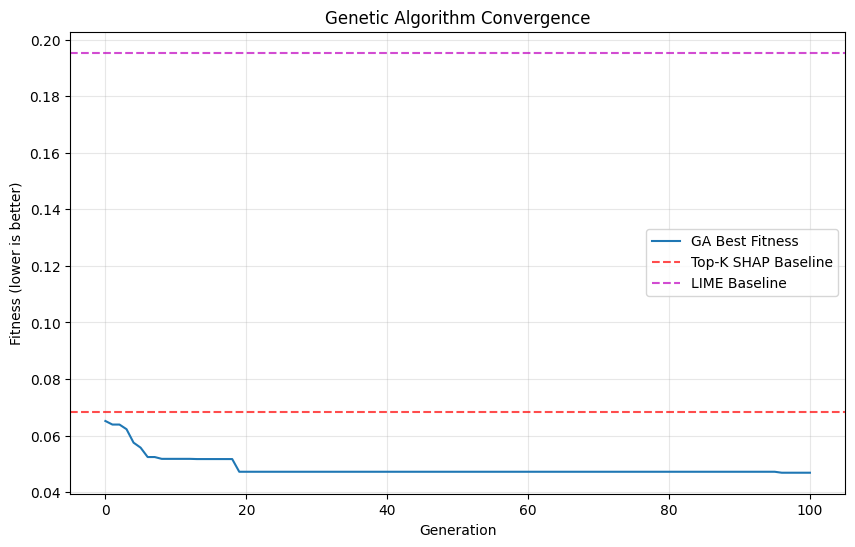

In [ ]:
# Run Genetic Algorithm
print("Running Genetic Algorithm...")
print("="*60)

ga_solution, ga_fitness, ga_history = genetic_algorithm(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    n_population=50,
    n_generations=100,
    crossover_rate=0.8,
    mutation_rate=0.1,
    random_state=RANDOM_STATE
)

print(f"\nGA Results:")
print(f"Best fitness: {ga_fitness:.6f}")
print(f"Number of selected features: {np.sum(ga_solution)}")
print(f"Selected feature indices: {np.where(ga_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[ga_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(ga_history, label='GA Best Fitness')
# Add baseline lines if available
try:
    if 'TOP_K_SHAP_FITNESS' in globals():
        plt.axhline(y=TOP_K_SHAP_FITNESS, color='r', linestyle='--', label='Top-K SHAP Baseline', alpha=0.7)
    if 'LIME_BASELINE_FITNESS' in globals():
        plt.axhline(y=LIME_BASELINE_FITNESS, color='m', linestyle='--', label='LIME Baseline', alpha=0.7)
except:
    pass
plt.xlabel('Generation')
plt.ylabel('Fitness (lower is better)')
plt.title('Genetic Algorithm Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 8. Particle Swarm Optimization (PSO)


Running Particle Swarm Optimization...

PSO Results:
Best fitness: 0.040559
Number of selected features: 6
Selected feature indices: [2, 4, 6, 18, 23, 24]
Selected feature names: ['sg', 'su', 'pc', 'htn', 'dm_no', 'dm_yes']


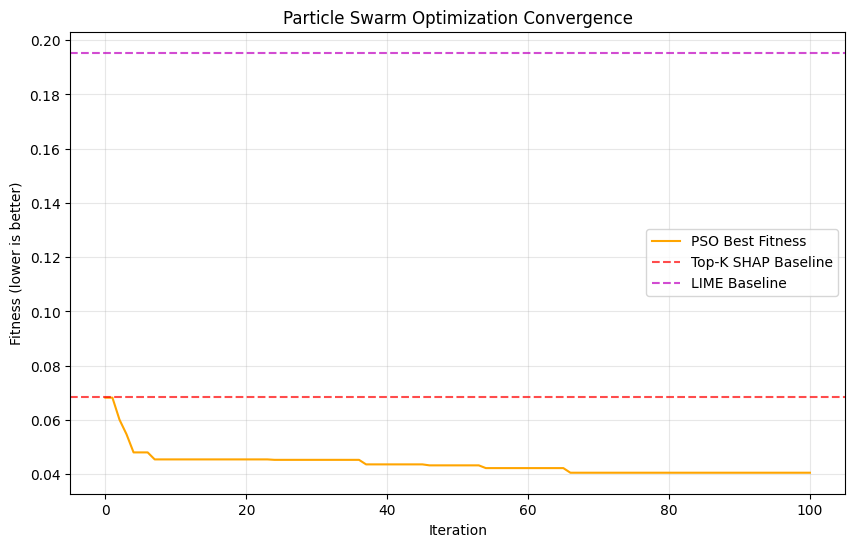

In [ ]:
# Run Binary PSO
print("Running Particle Swarm Optimization...")
print("="*60)

pso_solution, pso_fitness, pso_history = binary_pso(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    n_particles=30,
    n_iterations=100,
    w=0.7,
    c1=1.5,
    c2=1.5,
    random_state=RANDOM_STATE
)

print(f"\nPSO Results:")
print(f"Best fitness: {pso_fitness:.6f}")
print(f"Number of selected features: {np.sum(pso_solution)}")
print(f"Selected feature indices: {np.where(pso_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[pso_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(pso_history, label='PSO Best Fitness', color='orange')
# Add baseline lines if available
try:
    if 'TOP_K_SHAP_FITNESS' in globals():
        plt.axhline(y=TOP_K_SHAP_FITNESS, color='r', linestyle='--', label='Top-K SHAP Baseline', alpha=0.7)
    if 'LIME_BASELINE_FITNESS' in globals():
        plt.axhline(y=LIME_BASELINE_FITNESS, color='m', linestyle='--', label='LIME Baseline', alpha=0.7)
except:
    pass
plt.xlabel('Iteration')
plt.ylabel('Fitness (lower is better)')
plt.title('Particle Swarm Optimization Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 9. Simulated Annealing (SA) Optimization


Running Simulated Annealing...

SA Results:
Best fitness: 0.055874
Number of selected features: 10
Selected feature indices: [2, 3, 4, 5, 7, 13, 14, 18, 23, 24]
Selected feature names: ['sg', 'al', 'su', 'rbc', 'pcc', 'pot', 'hemo', 'htn', 'dm_no', 'dm_yes']


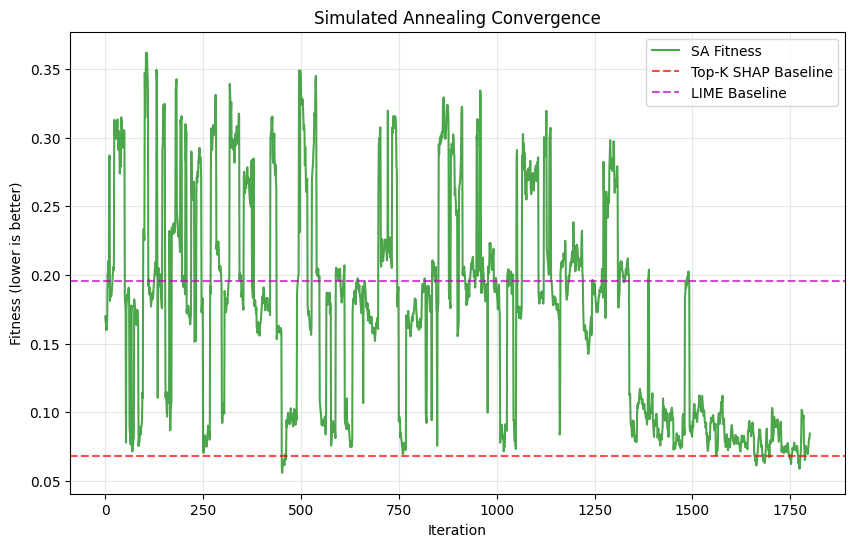

In [ ]:
# Run Simulated Annealing
print("Running Simulated Annealing...")
print("="*60)

sa_solution, sa_fitness, sa_history = simulated_annealing(
    fitness_func=fitness_wrapper,
    n_features=n_features,
    initial_temp=100.0,
    final_temp=0.01,
    cooling_rate=0.95,
    iterations_per_temp=10,
    random_state=RANDOM_STATE
)

print(f"\nSA Results:")
print(f"Best fitness: {sa_fitness:.6f}")
print(f"Number of selected features: {np.sum(sa_solution)}")
print(f"Selected feature indices: {np.where(sa_solution == 1)[0].tolist()}")
print(f"Selected feature names: {X_train.columns[sa_solution == 1].tolist()}")

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(sa_history, label='SA Fitness', color='green', alpha=0.7)
# Add baseline lines if available
try:
    if 'TOP_K_SHAP_FITNESS' in globals():
        plt.axhline(y=TOP_K_SHAP_FITNESS, color='r', linestyle='--', label='Top-K SHAP Baseline', alpha=0.7)
    if 'LIME_BASELINE_FITNESS' in globals():
        plt.axhline(y=LIME_BASELINE_FITNESS, color='m', linestyle='--', label='LIME Baseline', alpha=0.7)
except:
    pass
plt.xlabel('Iteration')
plt.ylabel('Fitness (lower is better)')
plt.title('Simulated Annealing Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 10. Result Comparison


Algorithm Comparison

Results Summary:
  Algorithm   Fitness  Num Features
0        GA  0.046842             7
1       PSO  0.040559             6
2        SA  0.055874            10


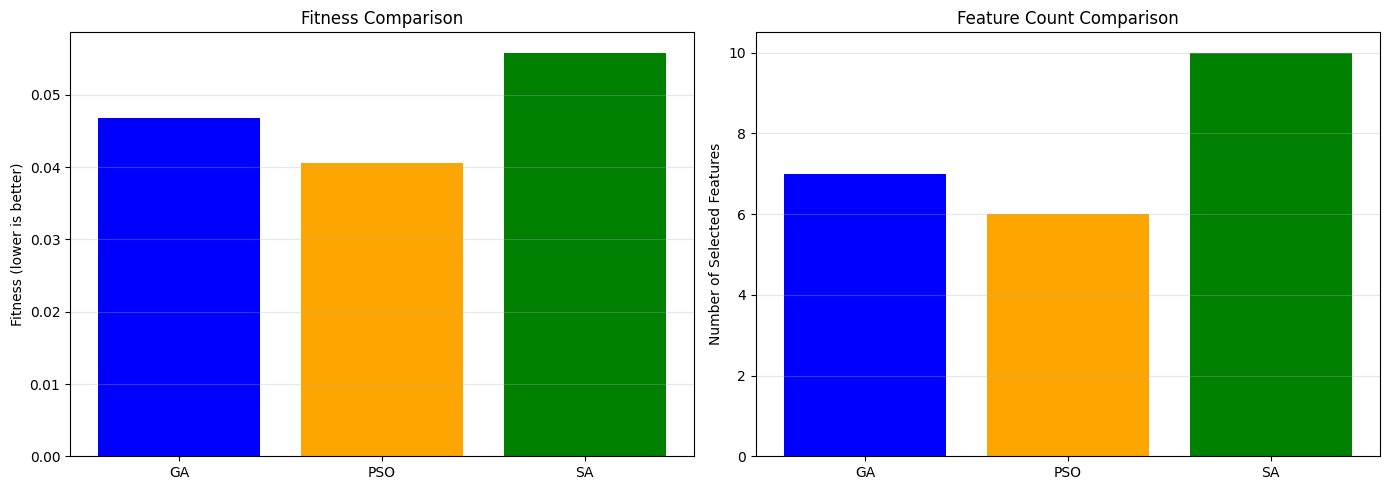

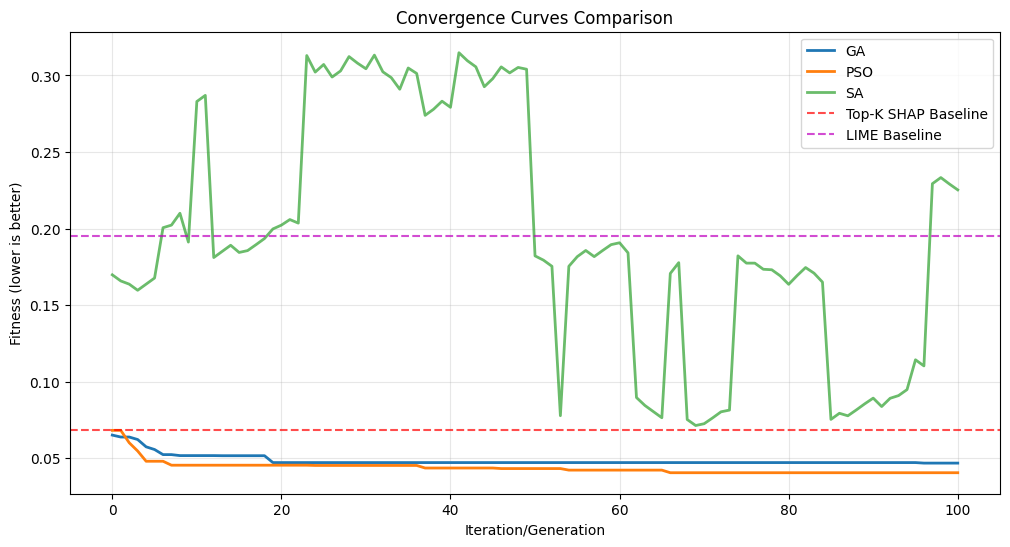

In [ ]:
# Compare all algorithms
print("="*60)
print("Algorithm Comparison")
print("="*60)

results = {
    'Algorithm': ['GA', 'PSO', 'SA'],
    'Fitness': [ga_fitness, pso_fitness, sa_fitness],
    'Num Features': [np.sum(ga_solution), np.sum(pso_solution), np.sum(sa_solution)]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fitness comparison
axes[0].bar(results_df['Algorithm'], results_df['Fitness'], color=['blue', 'orange', 'green'])
axes[0].set_ylabel('Fitness (lower is better)')
axes[0].set_title('Fitness Comparison')
axes[0].grid(True, alpha=0.3, axis='y')

# Number of features comparison
axes[1].bar(results_df['Algorithm'], results_df['Num Features'], color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Number of Selected Features')
axes[1].set_title('Feature Count Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Convergence curves comparison
plt.figure(figsize=(12, 6))
plt.plot(ga_history, label='GA', linewidth=2)
plt.plot(pso_history, label='PSO', linewidth=2)
plt.plot(sa_history[:len(ga_history)], label='SA', linewidth=2, alpha=0.7)
# Add baseline lines if available
try:
    if 'TOP_K_SHAP_FITNESS' in globals():
        plt.axhline(y=TOP_K_SHAP_FITNESS, color='r', linestyle='--', label='Top-K SHAP Baseline', alpha=0.7)
    if 'LIME_BASELINE_FITNESS' in globals():
        plt.axhline(y=LIME_BASELINE_FITNESS, color='m', linestyle='--', label='LIME Baseline', alpha=0.7)
except:
    pass
plt.xlabel('Iteration/Generation')
plt.ylabel('Fitness (lower is better)')
plt.title('Convergence Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 11. Detailed Analysis of Best Solution


Best algorithm: PSO

Best Solution Analysis:
Algorithm: PSO
Fitness: 0.040559
Number of features: 6

Selected features:
  1. sg
  2. su
  3. pc
  4. htn
  5. dm_no
  6. dm_yes

Prediction Fidelity:
  Full prediction: 0.9984
  Masked prediction: 0.9996
  Error: 0.0012

SHAP Fidelity:
  Normalized L2 error: 0.148902


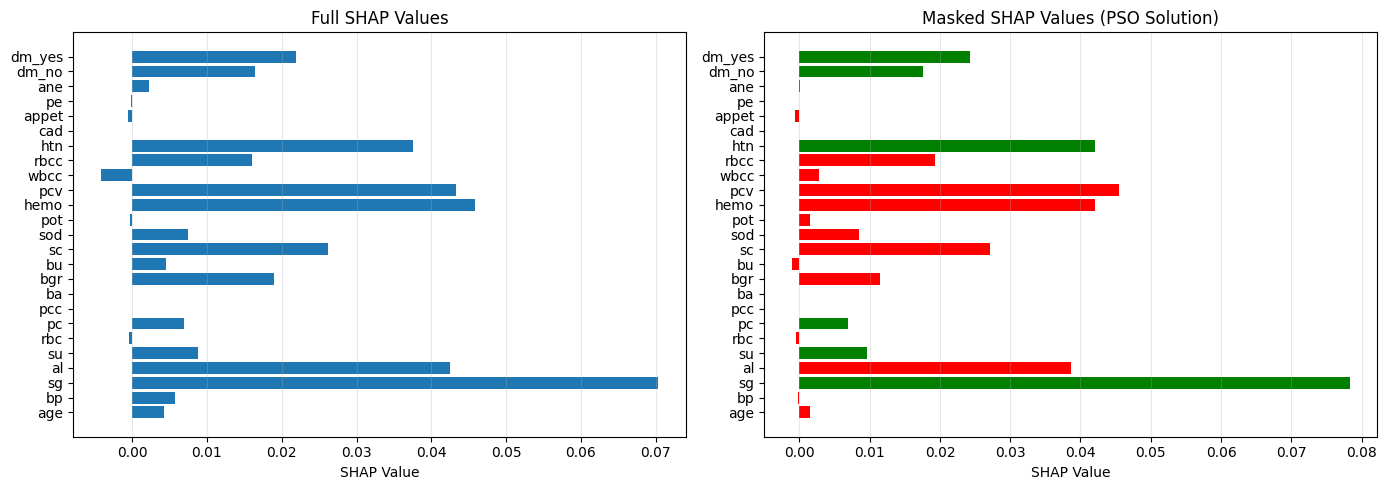

In [ ]:
# Find best solution overall
best_algo = results_df.loc[results_df['Fitness'].idxmin(), 'Algorithm']
print(f"Best algorithm: {best_algo}")

if best_algo == 'GA':
    best_solution = ga_solution
    best_fitness = ga_fitness
elif best_algo == 'PSO':
    best_solution = pso_solution
    best_fitness = pso_fitness
else:
    best_solution = sa_solution
    best_fitness = sa_fitness

# Evaluate best solution
print(f"\nBest Solution Analysis:")
print("="*60)
print(f"Algorithm: {best_algo}")
print(f"Fitness: {best_fitness:.6f}")
print(f"Number of features: {np.sum(best_solution)}")
print(f"\nSelected features:")
selected_features = X_train.columns[best_solution == 1]
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Compare predictions
X_masked_best = X_instance.copy()
baseline = X_train.mean(axis=0)
# Mask unselected features by iterating over columns (same approach as fitness function)
unselected_cols = X_instance.columns[~best_solution.astype(bool)]
for col in unselected_cols:
    baseline_val = float(baseline[col])
    # Convert column to float if needed to avoid dtype incompatibility
    if X_masked_best[col].dtype != float:
        X_masked_best[col] = X_masked_best[col].astype(float)
    X_masked_best.loc[:, col] = baseline_val

pred_full = rf_model.predict_proba(X_instance)[0, 1]
pred_masked = rf_model.predict_proba(X_masked_best)[0, 1]
pred_error = np.abs(pred_full - pred_masked)

print(f"\nPrediction Fidelity:")
print(f"  Full prediction: {pred_full:.4f}")
print(f"  Masked prediction: {pred_masked:.4f}")
print(f"  Error: {pred_error:.4f}")

# Compare SHAP values
# Reuse the same explainer and extract positive class as 1D vector
shap_masked, _ = compute_shap(rf_model, X_masked_best, explainer=shap_explainer)
# Ensure it's 1D and matches BASELINE_SHAP shape
shap_masked = np.array(shap_masked).flatten()
assert len(shap_masked.shape) == 1, f"Masked SHAP should be 1D, but got shape {shap_masked.shape}"
assert shap_masked.shape[0] == BASELINE_SHAP.shape[0], f"Shape mismatch: BASELINE_SHAP={BASELINE_SHAP.shape[0]}, masked={shap_masked.shape[0]}"

shap_error = np.linalg.norm(BASELINE_SHAP - shap_masked) / (np.linalg.norm(BASELINE_SHAP) + 1e-8)

print(f"\nSHAP Fidelity:")
print(f"  Normalized L2 error: {shap_error:.6f}")

# Visualize SHAP values comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full SHAP - ensure it's 1D
shap_values_full = np.array(BASELINE_SHAP).flatten()
# Handle case where BASELINE_SHAP might be 2D (if it's a list or has multiple classes)
if len(shap_values_full.shape) > 1:
    # If it's 2D with shape (n_features, n_classes), take the positive class (index 1)
    if shap_values_full.shape[1] == 2:
        shap_values_full = shap_values_full[:, 1]
    else:
        shap_values_full = shap_values_full.flatten()

# Ensure we have the correct number of features
n_features_shap = len(shap_values_full)
n_features_train = len(X_train.columns)

# Use the correct column names - match the length of SHAP values
if n_features_shap == n_features_train:
    feature_labels = list(X_train.columns)
else:
    # If there's a mismatch, use indices or adjust
    print(f"Warning: SHAP values have {n_features_shap} features, but X_train has {n_features_train} columns")
    feature_labels = [f'Feature {i}' for i in range(n_features_shap)]
    # Try to use X_train columns if possible
    if n_features_shap > n_features_train:
        # Pad with generic names
        feature_labels = list(X_train.columns) + [f'Feature {i}' for i in range(n_features_train, n_features_shap)]
    else:
        # Truncate
        feature_labels = list(X_train.columns[:n_features_shap])

axes[0].barh(range(len(shap_values_full)), shap_values_full)
axes[0].set_yticks(range(len(shap_values_full)))
axes[0].set_yticklabels(feature_labels)
axes[0].set_xlabel('SHAP Value')
axes[0].set_title('Full SHAP Values')
axes[0].grid(True, alpha=0.3, axis='x')

# Masked SHAP (only selected features) - ensure it's 1D
shap_values_masked = np.array(shap_masked).flatten()
if len(shap_values_masked.shape) > 1:
    if shap_values_masked.shape[1] == 2:
        shap_values_masked = shap_values_masked[:, 1]
    else:
        shap_values_masked = shap_values_masked.flatten()

# Ensure masked SHAP has same length as full SHAP
if len(shap_values_masked) != len(shap_values_full):
    print(f"Warning: Masked SHAP has {len(shap_values_masked)} values, but full SHAP has {len(shap_values_full)}")
    # Pad or truncate to match
    if len(shap_values_masked) < len(shap_values_full):
        shap_values_masked = np.pad(shap_values_masked, (0, len(shap_values_full) - len(shap_values_masked)), 'constant')
    else:
        shap_values_masked = shap_values_masked[:len(shap_values_full)]

axes[1].barh(range(len(shap_values_masked)), shap_values_masked,
             color=['green' if best_solution[i] else 'red' for i in range(min(len(best_solution), len(shap_values_masked)))])
axes[1].set_yticks(range(len(shap_values_masked)))
axes[1].set_yticklabels(feature_labels)
axes[1].set_xlabel('SHAP Value')
axes[1].set_title(f'Masked SHAP Values ({best_algo} Solution)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 12. Multiple Runs for Statistical Analysis


Running each algorithm 30 times for statistical analysis...
Run 5/30...
Run 10/30...
Run 15/30...
Run 20/30...
Run 25/30...
Run 30/30...

Statistical Summary:
            Fitness                               NumFeatures                \
               mean       std       min       max        mean       std min   
Algorithm                                                                     
GA         0.042644  0.001887  0.039274  0.046842    6.000000  0.870988   5   
PSO        0.040621  0.000999  0.038262  0.042591    5.666667  0.844182   4   
SA         0.051711  0.003834  0.044263  0.057655    9.033333  1.586219   6   

                 Runtime                                  
          max       mean       std        min        max  
Algorithm                                                 
GA          8  36.696392  2.497645  34.652270  43.798397  
PSO         8  22.578214  1.611910  21.211294  27.152326  
SA         13  12.896939  0.861200  12.286487  15.383745  

Runtime Com

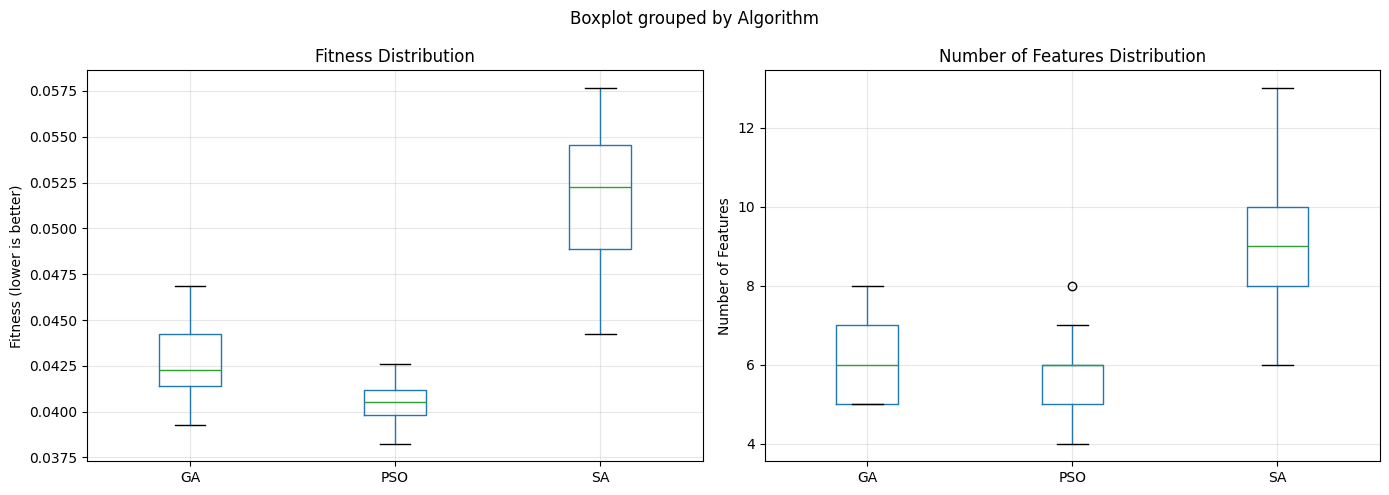


Results saved to: ../results/results_optimization.csv


In [ ]:
# Run each algorithm multiple times for statistical analysis
import time

N_RUNS = 30
print(f"Running each algorithm {N_RUNS} times for statistical analysis...")
print("="*60)

ga_results = []
pso_results = []
sa_results = []

ga_features = []
pso_features = []
sa_features = []

# Track convergence history and runtime
ga_convergence_history = []  # List of lists: each inner list is convergence history for one run
pso_convergence_history = []
sa_convergence_history = []

ga_runtimes = []
pso_runtimes = []
sa_runtimes = []

for run in range(N_RUNS):
    if (run + 1) % 5 == 0:
        print(f"Run {run + 1}/{N_RUNS}...")

    # GA
    start_time = time.time()
    ga_sol, ga_fit, ga_history = genetic_algorithm(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        n_population=50,
        n_generations=100,
        crossover_rate=0.8,
        mutation_rate=0.1,
        random_state=RANDOM_STATE + run
    )
    ga_runtime = time.time() - start_time
    ga_results.append(ga_fit)
    ga_features.append(np.sum(ga_sol))
    ga_convergence_history.append(ga_history)
    ga_runtimes.append(ga_runtime)

    # PSO
    start_time = time.time()
    pso_sol, pso_fit, pso_history = binary_pso(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        n_particles=30,
        n_iterations=100,
        w=0.7,
        c1=1.5,
        c2=1.5,
        random_state=RANDOM_STATE + run
    )
    pso_runtime = time.time() - start_time
    pso_results.append(pso_fit)
    pso_features.append(np.sum(pso_sol))
    pso_convergence_history.append(pso_history)
    pso_runtimes.append(pso_runtime)

    # SA
    start_time = time.time()
    sa_sol, sa_fit, sa_history = simulated_annealing(
        fitness_func=fitness_wrapper,
        n_features=n_features,
        initial_temp=100.0,
        final_temp=0.01,
        cooling_rate=0.95,
        iterations_per_temp=10,
        random_state=RANDOM_STATE + run
    )
    sa_runtime = time.time() - start_time
    sa_results.append(sa_fit)
    sa_features.append(np.sum(sa_sol))
    sa_convergence_history.append(sa_history)
    sa_runtimes.append(sa_runtime)

print("\nStatistical Summary:")
print("="*60)

stats_data = {
    'Algorithm': ['GA'] * N_RUNS + ['PSO'] * N_RUNS + ['SA'] * N_RUNS,
    'Fitness': ga_results + pso_results + sa_results,
    'NumFeatures': ga_features + pso_features + sa_features,
    'Runtime': ga_runtimes + pso_runtimes + sa_runtimes
}
stats_df = pd.DataFrame(stats_data)

summary = stats_df.groupby('Algorithm').agg({
    'Fitness': ['mean', 'std', 'min', 'max'],
    'NumFeatures': ['mean', 'std', 'min', 'max'],
    'Runtime': ['mean', 'std', 'min', 'max']
}).round(6)

print(summary)

# Runtime Summary
print("\n" + "="*60)
print("Runtime Comparison (Wall-clock time per run):")
print("="*60)
runtime_summary = stats_df.groupby('Algorithm')['Runtime'].agg(['mean', 'std', 'min', 'max']).round(4)
print(runtime_summary)
print("\nRuntime units: seconds")

# Box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stats_df.boxplot(column='Fitness', by='Algorithm', ax=axes[0])
axes[0].set_title('Fitness Distribution')
axes[0].set_ylabel('Fitness (lower is better)')
axes[0].set_xlabel('')
axes[0].grid(True, alpha=0.3)

stats_df.boxplot(column='NumFeatures', by='Algorithm', ax=axes[1])
axes[1].set_title('Number of Features Distribution')
axes[1].set_ylabel('Number of Features')
axes[1].set_xlabel('')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
import os
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)
results_file = os.path.join(results_dir, 'results_optimization.csv')
stats_df.to_csv(results_file, index=False)
print(f"\nResults saved to: {results_file}")


## 12.1. Convergence Curves Analysis
Visualize the convergence behavior of each algorithm across multiple runs. This shows:
- **Speed of convergence**: How quickly each algorithm reaches good solutions
- **Stability**: Consistency of convergence patterns across runs
- **Early vs late convergence**: Whether algorithms improve early or continue improving throughout



Convergence Curves Analysis


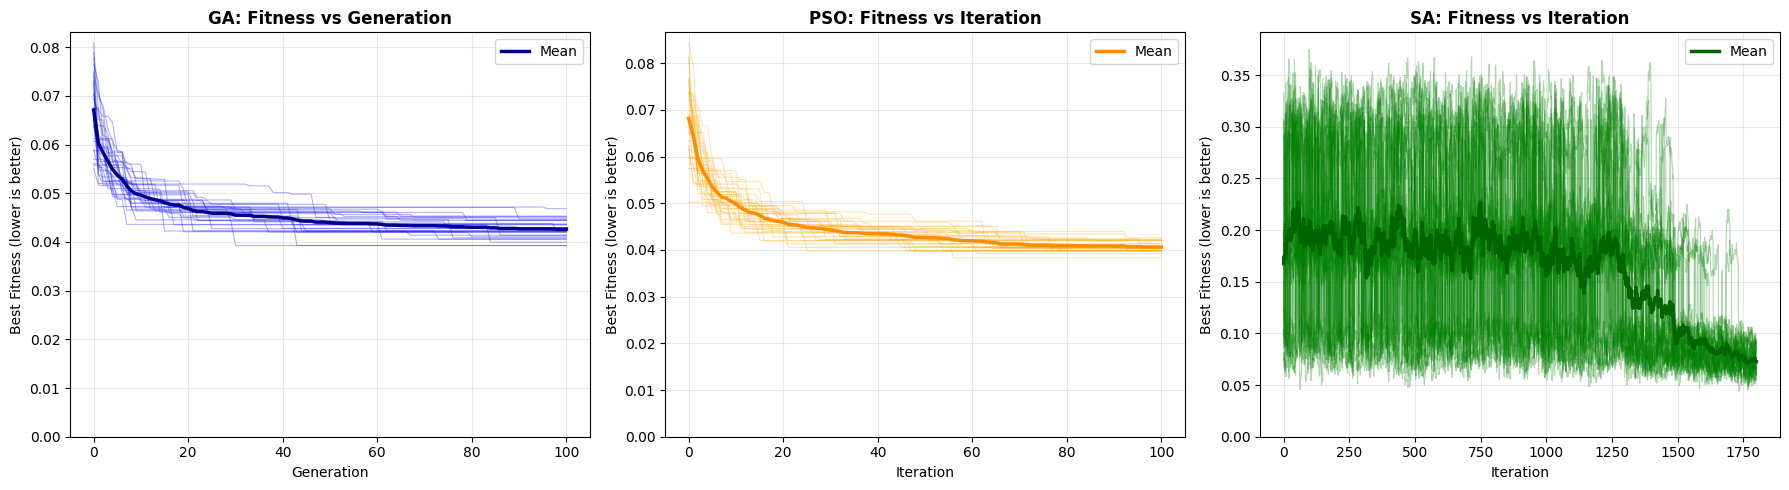


Combined Convergence Comparison (Mean Curves):


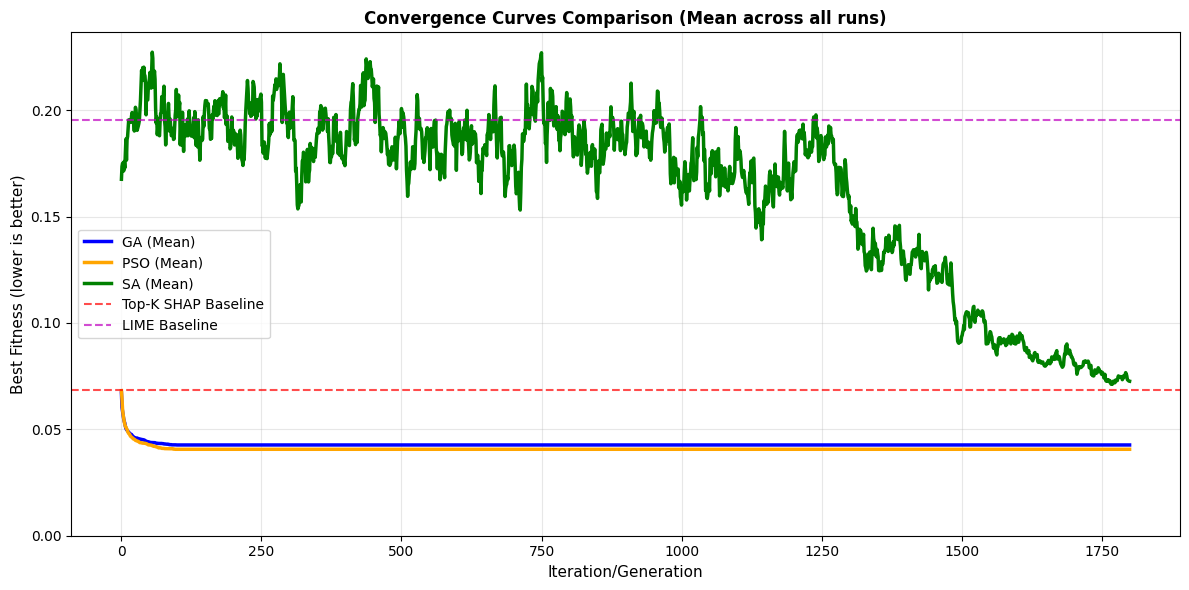


Convergence Statistics:
GA: 30 runs, mean length: 101.0 generations
PSO: 30 runs, mean length: 101.0 iterations
SA: 30 runs, mean length: 1801.0 iterations


In [ ]:
# Plot convergence curves for all runs
print("="*60)
print("Convergence Curves Analysis")
print("="*60)

# Create subplots for each algorithm
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GA Convergence
axes[0].set_title('GA: Fitness vs Generation', fontsize=12, fontweight='bold')
for i, history in enumerate(ga_convergence_history):
    axes[0].plot(history, alpha=0.3, linewidth=0.8, color='blue')
# Plot mean convergence
if len(ga_convergence_history) > 0:
    max_len = max(len(h) for h in ga_convergence_history)
    mean_history = []
    for gen in range(max_len):
        gen_values = [h[gen] if gen < len(h) else h[-1] for h in ga_convergence_history]
        mean_history.append(np.mean(gen_values))
    axes[0].plot(mean_history, linewidth=2.5, color='darkblue', label='Mean', zorder=10)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Best Fitness (lower is better)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim(bottom=0)

# PSO Convergence
axes[1].set_title('PSO: Fitness vs Iteration', fontsize=12, fontweight='bold')
for i, history in enumerate(pso_convergence_history):
    axes[1].plot(history, alpha=0.3, linewidth=0.8, color='orange')
# Plot mean convergence
if len(pso_convergence_history) > 0:
    max_len = max(len(h) for h in pso_convergence_history)
    mean_history = []
    for it in range(max_len):
        it_values = [h[it] if it < len(h) else h[-1] for h in pso_convergence_history]
        mean_history.append(np.mean(it_values))
    axes[1].plot(mean_history, linewidth=2.5, color='darkorange', label='Mean', zorder=10)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Best Fitness (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim(bottom=0)

# SA Convergence
axes[2].set_title('SA: Fitness vs Iteration', fontsize=12, fontweight='bold')
for i, history in enumerate(sa_convergence_history):
    axes[2].plot(history, alpha=0.3, linewidth=0.8, color='green')
# Plot mean convergence
if len(sa_convergence_history) > 0:
    max_len = max(len(h) for h in sa_convergence_history)
    mean_history = []
    for it in range(max_len):
        it_values = [h[it] if it < len(h) else h[-1] for h in sa_convergence_history]
        mean_history.append(np.mean(it_values))
    axes[2].plot(mean_history, linewidth=2.5, color='darkgreen', label='Mean', zorder=10)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Best Fitness (lower is better)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Combined convergence comparison (mean curves)
print("\nCombined Convergence Comparison (Mean Curves):")
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Normalize lengths for comparison
max_len = max(
    max(len(h) for h in ga_convergence_history) if ga_convergence_history else 0,
    max(len(h) for h in pso_convergence_history) if pso_convergence_history else 0,
    max(len(h) for h in sa_convergence_history) if sa_convergence_history else 0
)

# GA mean
if ga_convergence_history:
    ga_mean = []
    for gen in range(max_len):
        gen_values = [h[gen] if gen < len(h) else h[-1] for h in ga_convergence_history]
        ga_mean.append(np.mean(gen_values))
    ax.plot(ga_mean, linewidth=2.5, label='GA (Mean)', color='blue')

# PSO mean
if pso_convergence_history:
    pso_mean = []
    for it in range(max_len):
        it_values = [h[it] if it < len(h) else h[-1] for h in pso_convergence_history]
        pso_mean.append(np.mean(it_values))
    ax.plot(pso_mean, linewidth=2.5, label='PSO (Mean)', color='orange')

# SA mean
if sa_convergence_history:
    sa_mean = []
    for it in range(max_len):
        it_values = [h[it] if it < len(h) else h[-1] for h in sa_convergence_history]
        sa_mean.append(np.mean(it_values))
    ax.plot(sa_mean, linewidth=2.5, label='SA (Mean)', color='green')

# Add baseline lines if available
try:
    if 'TOP_K_SHAP_FITNESS' in globals():
        ax.axhline(y=TOP_K_SHAP_FITNESS, color='r', linestyle='--', label='Top-K SHAP Baseline', alpha=0.7)
    if 'LIME_BASELINE_FITNESS' in globals():
        ax.axhline(y=LIME_BASELINE_FITNESS, color='m', linestyle='--', label='LIME Baseline', alpha=0.7)
except:
    pass

ax.set_xlabel('Iteration/Generation', fontsize=11)
ax.set_ylabel('Best Fitness (lower is better)', fontsize=11)
ax.set_title('Convergence Curves Comparison (Mean across all runs)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Convergence statistics
print("\n" + "="*60)
print("Convergence Statistics:")
print("="*60)
print(f"GA: {len(ga_convergence_history)} runs, mean length: {np.mean([len(h) for h in ga_convergence_history]):.1f} generations")
print(f"PSO: {len(pso_convergence_history)} runs, mean length: {np.mean([len(h) for h in pso_convergence_history]):.1f} iterations")
print(f"SA: {len(sa_convergence_history)} runs, mean length: {np.mean([len(h) for h in sa_convergence_history]):.1f} iterations")


## 12.2. Runtime Comparison
Compare the computational efficiency (wall-clock time) of each algorithm across multiple runs.



Runtime Comparison Visualization


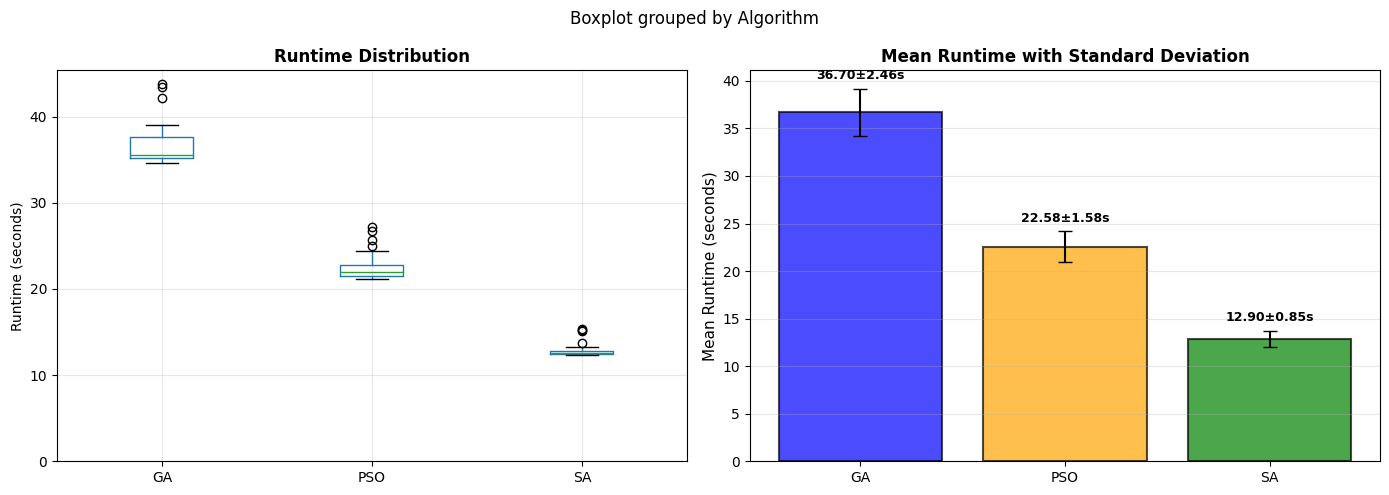


Detailed Runtime Statistics:
Algorithm  Mean (s)  Std (s)  Min (s)  Max (s)
       GA   36.6964   2.4557  34.6523  43.7984
      PSO   22.5782   1.5848  21.2113  27.1523
       SA   12.8969   0.8467  12.2865  15.3837

Relative Speed (compared to fastest algorithm):
GA: 2.85x slower (36.6964s)
PSO: 1.75x slower (22.5782s)
SA: Fastest (12.8969s)


In [ ]:
# Runtime comparison visualization
print("="*60)
print("Runtime Comparison Visualization")
print("="*60)

# Create runtime comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot for runtime
stats_df.boxplot(column='Runtime', by='Algorithm', ax=axes[0])
axes[0].set_title('Runtime Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Runtime (seconds)')
axes[0].set_xlabel('')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

# Bar plot with error bars
runtime_means = [np.mean(ga_runtimes), np.mean(pso_runtimes), np.mean(sa_runtimes)]
runtime_stds = [np.std(ga_runtimes), np.std(pso_runtimes), np.std(sa_runtimes)]
algorithms = ['GA', 'PSO', 'SA']
colors = ['blue', 'orange', 'green']

bars = axes[1].bar(algorithms, runtime_means, yerr=runtime_stds,
                   capsize=5, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Mean Runtime (seconds)', fontsize=11)
axes[1].set_title('Mean Runtime with Standard Deviation', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim(bottom=0)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(runtime_means, runtime_stds)):
    axes[1].text(i, mean + std + max(runtime_means) * 0.02,
                f'{mean:.2f}±{std:.2f}s',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed runtime statistics
print("\n" + "="*60)
print("Detailed Runtime Statistics:")
print("="*60)
runtime_stats = pd.DataFrame({
    'Algorithm': ['GA', 'PSO', 'SA'],
    'Mean (s)': [np.mean(ga_runtimes), np.mean(pso_runtimes), np.mean(sa_runtimes)],
    'Std (s)': [np.std(ga_runtimes), np.std(pso_runtimes), np.std(sa_runtimes)],
    'Min (s)': [np.min(ga_runtimes), np.min(pso_runtimes), np.min(sa_runtimes)],
    'Max (s)': [np.max(ga_runtimes), np.max(pso_runtimes), np.max(sa_runtimes)]
})
print(runtime_stats.round(4).to_string(index=False))

# Speed comparison (relative to fastest)
fastest_mean = min(runtime_means)
print("\n" + "="*60)
print("Relative Speed (compared to fastest algorithm):")
print("="*60)
for algo, mean_time in zip(algorithms, runtime_means):
    speedup = fastest_mean / mean_time
    slowdown = mean_time / fastest_mean
    if speedup == 1.0:
        print(f"{algo}: Fastest ({mean_time:.4f}s)")
    else:
        print(f"{algo}: {slowdown:.2f}x {'slower' if slowdown > 1 else 'faster'} ({mean_time:.4f}s)")


## 13. Statistical Significance Testing (Wilcoxon Rank-Sum Test)

The Wilcoxon rank-sum test (also called Mann–Whitney U test) compares two independent distributions to determine if they have significantly different fitness distributions.

**Null hypothesis (H₀):** The two algorithms have the same fitness distribution  
**Alternative hypothesis (H₁):** The two algorithms have different distributions  
**Significance level:** α = 0.05

We compare each pair:
- GA vs PSO
- GA vs SA  
- PSO vs SA
- **PSO vs SHAP (SOTA)**
- **PSO vs LIME (SOTA)**
- **GA vs SHAP (SOTA)**


In [ ]:
# Import scipy.stats for Wilcoxon rank-sum test
from scipy.stats import mannwhitneyu

print("="*60)
print("Wilcoxon Rank-Sum Test (Mann-Whitney U Test)")
print("="*60)
print("\nNull Hypothesis (H₀): The two algorithms have the same fitness distribution")
print("Alternative Hypothesis (H₁): The two algorithms have different distributions")
print("Significance Level: α = 0.05\n")

# Create SOTA baseline results arrays (deterministic baselines repeated for each run)
# Since SHAP and LIME baselines are deterministic, we repeat the same value for all runs
n_runs = len(ga_results)  # Get number of runs from existing results
shap_baseline_results = np.full(n_runs, TOP_K_SHAP_FITNESS) if 'TOP_K_SHAP_FITNESS' in globals() else None
lime_baseline_results = np.full(n_runs, LIME_BASELINE_FITNESS) if 'LIME_BASELINE_FITNESS' in globals() else None

# Perform pairwise comparisons
comparisons = [
    ('GA', 'PSO', ga_results, pso_results),
    ('GA', 'SA', ga_results, sa_results),
    ('PSO', 'SA', pso_results, sa_results)
]

# Add SOTA comparisons if baselines are available
if shap_baseline_results is not None:
    comparisons.extend([
        ('PSO', 'SHAP', pso_results, shap_baseline_results),
        ('GA', 'SHAP', ga_results, shap_baseline_results)
    ])

if lime_baseline_results is not None:
    comparisons.append(('PSO', 'LIME', pso_results, lime_baseline_results))

results_table = []

for algo1, algo2, results1, results2 in comparisons:
    # Perform Mann-Whitney U test (Wilcoxon rank-sum test)
    statistic, p_value = mannwhitneyu(results1, results2, alternative='two-sided')

    # Determine significance
    is_significant = p_value < 0.05

    # Determine which algorithm is better (lower fitness is better)
    mean1 = np.mean(results1)
    mean2 = np.mean(results2)
    better_algo = algo1 if mean1 < mean2 else algo2

    # Format p-value for display
    if p_value < 0.001:
        p_value_str = '< 0.001'
    elif p_value < 0.01:
        p_value_str = f'{p_value:.6f} (< 0.01)'
    else:
        p_value_str = f'{p_value:.6f}'

    results_table.append({
        'Comparison': f'{algo1} vs {algo2}',
        'p-value': p_value_str,
        'Significant?': 'Yes' if is_significant else 'No',
        'Better Algorithm': better_algo,
        f'{algo1} Mean': f'{mean1:.6f}',
        f'{algo2} Mean': f'{mean2:.6f}'
    })

    print(f"{algo1} vs {algo2}:")
    print(f"  U-statistic: {statistic:.2f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Significant difference? {'Yes' if is_significant else 'No'} (α = 0.05)")
    if is_significant:
        print(f"  → Reject H₀: The algorithms have significantly different fitness distributions")
        print(f"  → Better algorithm: {better_algo} (lower mean fitness: {min(mean1, mean2):.6f})")
    else:
        print(f"  → Fail to reject H₀: No significant difference in fitness distributions")
    print(f"  {algo1} mean fitness: {mean1:.6f}")
    print(f"  {algo2} mean fitness: {mean2:.6f}")
    print()

# Create summary table
print("="*60)
print("Summary Table")
print("="*60)
results_summary_df = pd.DataFrame(results_table)
# Reorder columns for better readability
column_order = ['Comparison', 'p-value', 'Significant?', 'Better Algorithm']
# Add mean columns dynamically
for col in results_summary_df.columns:
    if col not in column_order:
        column_order.append(col)
results_summary_df = results_summary_df[column_order]
print(results_summary_df.to_string(index=False))
print()

# Interpretation
print("="*60)
print("Interpretation:")
print("="*60)
significant_count = sum(1 for r in results_table if r['Significant?'] == 'Yes')
if significant_count == 0:
    print("No significant differences found between any algorithm pairs.")
    print("All algorithms perform similarly in terms of fitness distribution.")
elif significant_count == len(results_table):
    print("All pairwise comparisons show significant differences.")
    print("The algorithms have distinct fitness distributions.")
else:
    print(f"{significant_count} out of {len(results_table)} comparisons show significant differences.")


Wilcoxon Rank-Sum Test (Mann-Whitney U Test)

Null Hypothesis (H₀): The two algorithms have the same fitness distribution
Alternative Hypothesis (H₁): The two algorithms have different distributions
Significance Level: α = 0.05

GA vs PSO:
  U-statistic: 750.00
  p-value: 0.000009
  Significant difference? Yes (α = 0.05)
  → Reject H₀: The algorithms have significantly different fitness distributions
  → Better algorithm: PSO (lower mean fitness: 0.040621)
  GA mean fitness: 0.042644
  PSO mean fitness: 0.040621

GA vs SA:
  U-statistic: 13.00
  p-value: 0.000000
  Significant difference? Yes (α = 0.05)
  → Reject H₀: The algorithms have significantly different fitness distributions
  → Better algorithm: GA (lower mean fitness: 0.042644)
  GA mean fitness: 0.042644
  SA mean fitness: 0.051711

PSO vs SA:
  U-statistic: 0.00
  p-value: 0.000000
  Significant difference? Yes (α = 0.05)
  → Reject H₀: The algorithms have significantly different fitness distributions
  → Better algorithm: 

# 14. SOTA Baseline Comparision: Top-K SHAP VS Metaheuristics

SOTA Baseline Comparison: Top-K SHAP, LIME vs. Metaheuristic
Heuristic (Best) found 6 features.
Using existing Top-K SHAP baseline (K=17)...
Using existing LIME baseline (15 features)...

Results Comparison:
Approach                       | Fitness      | Num Features
------------------------------------------------------------
Top-K SHAP Baseline            | 0.068397     | 17          
LIME Baseline                  | 0.195365     | 15          
Best Metaheuristic (PSO)       | 0.040559     | 6           

✓ SUCCESS: The PSO optimization outperformed the Top-K SHAP baseline by 40.70%
✓ SUCCESS: The PSO optimization outperformed the LIME baseline by 79.24%

Feature Overlap Analysis (Top-K SHAP):
  Common features found by both: 6
  Common features: ['dm_no', 'dm_yes', 'htn', 'pc', 'sg', 'su']
  Unique features found by PSO: []
  Unique features in Top-K SHAP: ['age', 'al', 'bgr', 'bp', 'bu', 'hemo', 'pcv', 'rbcc', 'sc', 'sod', 'wbcc']

Feature Overlap Analysis (LIME):
  Common feature

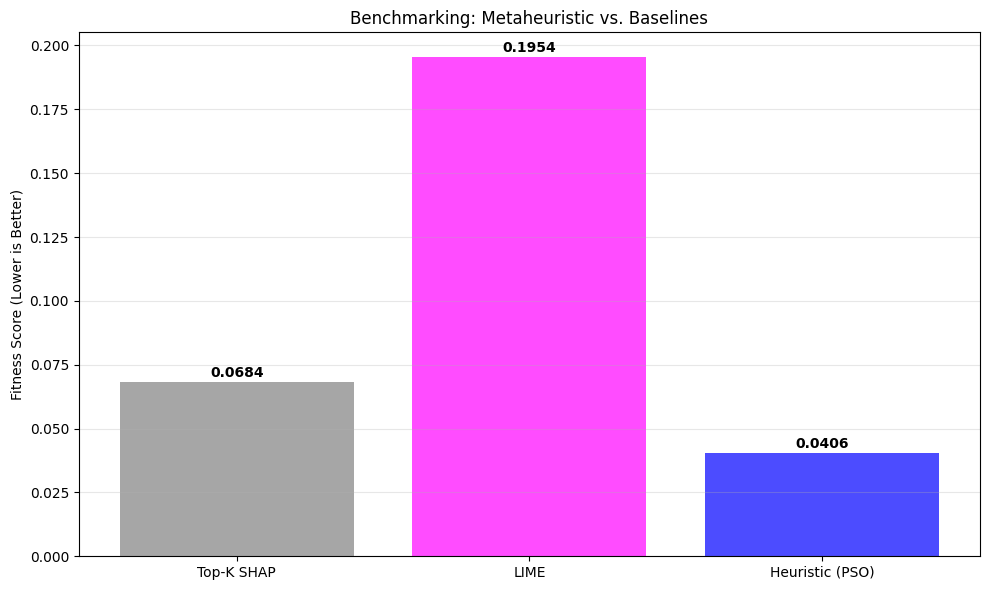

In [ ]:
print("="*60)
print("SOTA Baseline Comparison: Top-K SHAP, LIME vs. Metaheuristic")
print("="*60)

# Check if baseline variables exist (from earlier cells)
use_existing_top_k = 'TOP_K_SHAP_FITNESS' in globals() and 'top_k_shap_mask' in globals()
use_existing_lime = 'LIME_BASELINE_FITNESS' in globals() and 'lime_mask' in globals()

# 1. Get the number of features from best solution
k = int(np.sum(best_solution))
print(f"Heuristic (Best) found {k} features.")

# 2. Use existing Top-K SHAP baseline if available, otherwise compute it
if use_existing_top_k:
    top_k_fitness = TOP_K_SHAP_FITNESS
    top_k_mask = top_k_shap_mask
    n_top_k = int(np.sum(top_k_mask))
    print(f"Using existing Top-K SHAP baseline (K={n_top_k})...")
else:
    print(f"Computing Top-K SHAP baseline (K={k})...")
    # Calculate SHAP Importance (Absolute values)
    shap_importance = np.abs(BASELINE_SHAP)
    # Get indices of the k largest SHAP values
    top_k_indices = np.argsort(shap_importance)[-k:]
    top_k_mask = np.zeros(n_features, dtype=int)
    top_k_mask[top_k_indices] = 1
    top_k_fitness = fitness_wrapper(top_k_mask)
    n_top_k = k

# 3. Use existing LIME baseline if available
if use_existing_lime:
    lime_fitness = LIME_BASELINE_FITNESS
    lime_mask_var = lime_mask
    n_lime = int(np.sum(lime_mask_var))
    print(f"Using existing LIME baseline ({n_lime} features)...")
else:
    lime_fitness = None
    lime_mask_var = None
    n_lime = 0
    print("LIME baseline not available (run LIME baseline cell first).")

# 4. Compare Results
print(f"\nResults Comparison:")
print(f"{'Approach':<30} | {'Fitness':<12} | {'Num Features':<12}")
print("-" * 60)
print(f"{'Top-K SHAP Baseline':<30} | {top_k_fitness:<12.6f} | {n_top_k:<12}")
if lime_fitness is not None:
    print(f"{'LIME Baseline':<30} | {lime_fitness:<12.6f} | {n_lime:<12}")
print(f"{'Best Metaheuristic (' + best_algo + ')':<30} | {best_fitness:<12.6f} | {k:<12}")

# Calculate improvements
improvement_topk = ((top_k_fitness - best_fitness) / top_k_fitness) * 100 if top_k_fitness > 0 else 0
if best_fitness < top_k_fitness:
    print(f"\n✓ SUCCESS: The {best_algo} optimization outperformed the Top-K SHAP baseline by {improvement_topk:.2f}%")
else:
    print(f"\nThe Top-K SHAP baseline performed better or equal to the heuristic.")

if lime_fitness is not None:
    improvement_lime = ((lime_fitness - best_fitness) / lime_fitness) * 100 if lime_fitness > 0 else 0
    if best_fitness < lime_fitness:
        print(f"✓ SUCCESS: The {best_algo} optimization outperformed the LIME baseline by {improvement_lime:.2f}%")
    else:
        print(f"The LIME baseline performed better or equal to the heuristic.")

# 5. Visualization
# Create single subplot (we'll show all baselines in one chart)
plt.figure(figsize=(10, 6))

# Bar chart comparison
labels = ['Top-K SHAP', f'Heuristic ({best_algo})']
fitness_values = [top_k_fitness, best_fitness]
colors = ['gray', 'blue']

if lime_fitness is not None:
    labels.insert(1, 'LIME')
    fitness_values.insert(1, lime_fitness)
    colors.insert(1, 'magenta')

plt.bar(labels, fitness_values, color=colors, alpha=0.7)
plt.ylabel('Fitness Score (Lower is Better)')
plt.title(f'Benchmarking: Metaheuristic vs. Baselines')
plt.grid(True, alpha=0.3, axis='y')

# Add values on top of bars
for i, v in enumerate(fitness_values):
    plt.text(i, v + (max(fitness_values)*0.01), f"{v:.4f}", ha='center', fontweight='bold')

# Feature overlap analysis
heuristic_feats = set(X_train.columns[best_solution == 1])
topk_feats = set(X_train.columns[top_k_mask == 1])
common_topk = heuristic_feats.intersection(topk_feats)
unique_heuristic_topk = heuristic_feats - topk_feats

print(f"\nFeature Overlap Analysis (Top-K SHAP):")
print(f"  Common features found by both: {len(common_topk)}")
print(f"  Common features: {sorted(common_topk)}")
print(f"  Unique features found by {best_algo}: {sorted(unique_heuristic_topk)}")
print(f"  Unique features in Top-K SHAP: {sorted(topk_feats - heuristic_feats)}")

if lime_fitness is not None and lime_mask_var is not None:
    lime_feats = set(X_train.columns[lime_mask_var == 1])
    common_lime = heuristic_feats.intersection(lime_feats)
    unique_heuristic_lime = heuristic_feats - lime_feats
    
    print(f"\nFeature Overlap Analysis (LIME):")
    print(f"  Common features found by both: {len(common_lime)}")
    print(f"  Common features: {sorted(common_lime)}")
    print(f"  Unique features found by {best_algo}: {sorted(unique_heuristic_lime)}")
    print(f"  Unique features in LIME: {sorted(lime_feats - heuristic_feats)}")
    
    # Venn diagram or comparison visualization
    all_three = heuristic_feats.intersection(topk_feats).intersection(lime_feats)
    print(f"\nFeatures found by all three methods: {len(all_three)}")
    if len(all_three) > 0:
        print(f"  {sorted(all_three)}")

plt.tight_layout()
plt.show()